# Forecasting Model: The case of the New York subway usage

## The driving question: to Forecast the number of people that uses the metro

There are many approaches to tackle this problem. Consistely defining what to answer is the first step. For instance, are we trying to forecast months, weeks or days ahead? For each of these there should be a slightly different approach. Moreover, are we aiming to forecast at a high level or do we desire to tackle specific need of each station individually or even at a control unit level? It is imperative that we define our goal. Therefore, this is the first step.

For the posing question underlying the greater driving question the proposition is to firstly understand the subway usage at a high level and with the data provided by MTA assuming the absence of external datasets that may have influence in the subway usage such as weather forecast, festivals, holidays, etc. In that sense, the driving question becomes: can we forecast a high level demand for days, weeks or even months?

**The proposal here is therefore to perform an exploratory analysis of the data and suggest a forecast model at a daily level.**

## Summary of Dataset analysis and strategies for handling

 As currently presented, the dataset is comprised of 10 columns and extensive number of registries which may be a sign that for the purposes of the investigation there might be necessary to group and reduce some of the data. The original columns are:

*   **CA** = Control Area (A002)
*   **UNIT** = Remote Unit for a station (R051) 
*   **SCP** = Subunit Channel Position represents an specific address for a device (02-00-00)
*   **STATION** = Represents the station name the device is located at 
*   **LINENAME** = Represents all train lines that can be boarded at this station Normally lines are represented by one character. LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains. 
*   **DIVISION** = Represents the Line originally the station belonged to BMT, IRT, or IND
*   **DATE** = Represents the date (MM-DD-YY) 
*   **TIME** = Represents the time (hhmmss) for a scheduled audit event 
*   **DESC** = Represent the REGULAR scheduled audit event (Normally occurs every 4 hours) 1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 2. Additionally, there may be a RECOVR AUD entry This refers to a missed audit that was recovered. 
*   **ENTRIES** = The cumulative entry register value for a device 
*   **EXITS** = The cumulative exit register value for a device

Since our goal is to forecast, **DATE** and **TIME** are absolutely imperative. **ENTRIES** and **EXITS** are the time and space relative variables. However, the space axis is very granular and should be understood at a higher level, grouping by **STATION**. However, due to the nature of **ENTRIES** and **EXITS**, we cannot at first drop more granular columns such as **CA**, **UNIT** and **SCP**.
 
 Another relevant fact is that **ENTRIES** and **EXITS** are cumulative quantities at any given time thus demanding a calculation to determine the differences.








## Libraries

In [68]:
# Force numpy version at 1.19.5
!pip install numpy==1.19.5 --quiet

In [ ]:
# Install pmdarima to evaluate parameters for SARIMAX models
!pip install pmdarima==1.8.2 --quiet

In [1]:
!pip show pmdarima

Name: pmdarima
Version: 1.8.2
Summary: Python's forecast::auto.arima equivalent
Home-page: http://alkaline-ml.com/pmdarima
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, joblib, numpy, Cython, statsmodels, scikit-learn, pandas, urllib3, setuptools
Required-by: 


In [2]:
!pip show keras

Name: keras
Version: 2.9.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: keras-vis


In [ ]:
# Install tensorflow for ML
!pip install tensorflow==2.5 --quiet

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: tensorboard, grpcio, absl-py, google-pasta, astunparse, typing-extensions, numpy, flatbuffers, wrapt, opt-einsum, keras-preprocessing, six, wheel, h5py, gast, protobuf, termcolor, tensorflow-estimator, keras-nightly
Required-by: kapre


In [4]:
# Import relevant libraries to perform data cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import psutil
import math
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
warnings.filterwarnings('ignore')

## Data preparation

In [5]:
# Firstly, we mount the drive to access files stored at a given google drive repository
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Create a general path in which the repository is stored and will be then accessed
path = '/content/drive/MyDrive/Educação/Estudo de Caso: Metro de Nova Iorque/dados/'

# The initial file will be identifies as a string to be passed later to read_csv
# After that, the remaning files are passed through a list with strings identifying each file
file1 = '2010.csv'
csv_list = ['2011.csv','2012.csv','2013.csv','2014.csv','2015.csv','2016.csv','2017.csv']

In [7]:
# A function is declared in order to perform initial cleaning 

def HM_Data_Cleanse(file):
  # This dictionary is used to store the columns to be considered in the dataframe and their respective types
  # By eliminating redundant columns such as LINENAME, DIVISION and DESC it is possible to reduce data size
  df = pd.read_csv(path+file)
  
  # Consider only regular audit events
  df = df.loc[(df.desc == 'REGULAR'),:]

  # Entries and exits need to be sorted in order to perform difference calculations
  # Sort by using the method .sort_values in columns CA, UNIT, SCP, STATION and TIME in order
  df = df.sort_values(by=['ca','unit','scp','linename','division','station','time'])

  # Set TIME as DATETIME and INDEX of the dataframe
  df['time'] = pd.to_datetime(df['time'])
  #df = df.set_index('time')

  # For the purposes of the dataset, it does not matter its DESC so long the data is available
  # By definition, DESC is an event of measuring the cumulative quantities of entries and exits
  # Hence, if there are multiple DESC at any given time, using drop_duplicates method redundant data is eliminated
  df = df.drop_duplicates()

  # Now the column desc will no longer be necessary, therefore, can be dropped
  #df = df.drop(columns = ['linename','division','desc'])

  # Calculatem differences in entries and exits at t = 0 and t = t - 1
  df['entries'] = df['entries'].diff(periods=1)
  df['exits'] = df['exits'].diff(periods=1)

  # When the aggregate ca + unit + scp + station changes, the difference between entries and exits no longer holds logic
  # By using a mask, drop the instances where this event occurs 
  df = df[(df.ca == df.shift(1).ca) & (df.unit == df.shift(1).unit) & (df.scp == df.shift(1).scp) & (df.station == df.shift(1).station)]
  
  # Another important step is to remove potential NaN values
  df = df.dropna()
  
  return df

In [8]:
# A function is declared now to remove potential outliers when analysing data

# This inputs for this function will be a dataframe and the string of a specific column 
def remove_outlier(df_in, col_name):
    # Compute the first quartile
    q1 = df_in[col_name].quantile(0.25)
    # Compute the third quartile
    q3 = df_in[col_name].quantile(0.75)
    # Compute the interquartile range
    iqr = q3-q1
    # Compute low and high limits
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    # A new dataframe is returned by using a mask to slice data
    df_out = df_in.loc[(df_in[col_name] > low) & (df_in[col_name] < high)]
    return df_out

In [ ]:
# Initial data cleaning is performed in the first csv file
df1 = HM_Data_Cleanse(file1)
# Necessary: measure memory usage due to limited memory availability and large dataset
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 17.6
RAM Used (GB): 5.455798272


In [ ]:
# Create a master.csv as a master file to store all data through steps
df1.to_csv(path + 'master.csv', index = False)

# Measure memory usage due to limited memory availability
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 13.9
RAM Used (GB): 5.382877184


In [ ]:
# For each individual file in the list csv_list the function HM_DATA_CLEANSE is applied for prior cleaning
# Due to large data size, this has to be done in parts
for csv_file in csv_list:
  df = HM_Data_Cleanse(csv_file)
  # Save current df dataframe to the master.csv appending information
  df.to_csv(path+'master.csv', mode = 'a', header = False, index = False)

# Monitor the usage of memory to avoid crashing
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 25.0
RAM Used (GB): 6.280818688


In [ ]:
# Create a dataframe with the whole dataset from 2010 to 2017
# Due to size and memory availability, chunking is necessary
df = pd.read_csv(path + 'master.csv', chunksize = 100000)

In [ ]:
# Initiate an empty dataframe that will be the master dataframe
# master_in and master_out represent a daily usage dataframe
master_in = pd.DataFrame()
master_out = pd.DataFrame()
for chunk in df:
  summary = chunk 
  # Transform the time column into string in order to allow string manipulation
  # From time (datetime), obtain date by extractin the first 10 characters
  # The time detail although importante, for the master_daily dataframe is not important
  summary['Date'] = summary['time'].str[:10]
    
  # Since the differences are already taken into account, data from CA, UNIT and SCP are no longer relevant
  # This is an opportunity to reduce data size, hence, a groupby is applied
  # Reset index is used to return to a DataFrame format
  summary_in = summary.groupby(['Date','station'])['entries'].sum().reset_index()#.set_index('Date')
  summary_out = summary.groupby(['Date','station'])['exits'].sum().reset_index()#.set_index('Date')
  summary_in = remove_outlier(summary_in,'entries')
  summary_out = remove_outlier(summary_out,'exits')

  # The initiated dataframes master_in and out are appended by the chunk of the summary dataframe at each iteration
  master_in = master_in.append(summary_in, ignore_index=False)
  master_out = master_out.append(summary_out, ignore_index=False)

In [ ]:
# Create a reduced master file with only dates and entries
master_in.to_csv(path + 'master_daily_entries.csv', index = False)

# Create a reduced master file with only dates and exits
master_out.to_csv(path + 'master_daily_exits.csv', index = False)

## Creation of Dataframes for Analysis

Now that we have managed to create a master file in **master.csv** with all relevant data from **2010.csv** to **2017.csv**, we can access its contents at any given time. However, a more aggregated dataset is created through **master_entries_daily.csv** and **master_exits_daily.csv** with reduced amount of data and therefore better performance. These dataframes can in turn be used to derived monthly data or grouped data by station.

### Daily dataframes

In [10]:
# Set an option to display the numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [11]:
# Create variables as paths to file directory
path = '/content/drive/MyDrive/Educação/Estudo de Caso: Metro de Nova Iorque/dados/'
file_in = 'master_daily_entries.csv'
file_out = 'master_daily_exits.csv'

In [12]:
# Read the created csv files in master_daily_entries and master_daily_exits
daily_entries_df = pd.read_csv(path + file_in)
daily_exits_df = pd.read_csv(path + file_out)

# Convert entries and exits into thousands of people
daily_entries_df['entries'] = daily_entries_df['entries'].div(1000)
daily_exits_df['exits'] = daily_exits_df['exits'].div(1000)

# Convter the DATE column to datetime format
daily_exits_df['Date'] = pd.to_datetime(daily_exits_df['Date'], errors='coerce')
daily_entries_df['Date'] = pd.to_datetime(daily_entries_df['Date'], errors='coerce')

Since the subway usage is a time series, it is not plausible to observe days with ridership equal to zero. Such values are result of data handling at **SCP** level. The approach is to mimic the daily behaviour of ridership at a given point in time with its value backshifted in 7 days so that Mondays are comparable to Mondays and so on.

In [13]:
# Create DAILY dataframes for exits DAILY_EX and entries DAILY_EN
DAILY_EX = daily_exits_df.groupby(pd.Grouper(key='Date', freq='D'))['exits'].sum().to_frame()
DAILY_EN = daily_entries_df.groupby(pd.Grouper(key='Date', freq='D'))['entries'].sum().to_frame()

In [14]:
# With the method .reset_index, create a numeric index to iterate from
# In the shape[0] of DAILY_EX, search for zero values at each instance and replace them with the series value backshifted by 7 days
# Whenever not possible to do so, consider the median of the data (main within the first 6 days)

# First for the exits time series
DAILY_EX = DAILY_EX.reset_index()
for i in range(DAILY_EX.shape[0]):
  if i < 6 and DAILY_EX['exits'][i] == 0:
    DAILY_EX['exits'][i] = DAILY_EX['exits'].quantile(0.5)
  elif DAILY_EX['exits'][i] == 0:
    DAILY_EX['exits'][i] = DAILY_EX.shift(7)['exits'][i]

# Finally for the entries time series
DAILY_EN = DAILY_EN.reset_index()
for i in range(DAILY_EN.shape[0]):
  if i < 6 and DAILY_EN['entries'][i] == 0:
    DAILY_EN['entries'][i] = DAILY_EN['entries'].quantile(0.5)
  elif DAILY_EN['entries'][i] == 0:
    DAILY_EN['entries'][i] = DAILY_EN.shift(7)['entries'][i]

In [15]:
# Recreate the dataframe for MONTH exits and entries time series by grouping the dates adjusting the frequency of the grouper method to M
MONTH_EX = DAILY_EX.groupby(pd.Grouper(key='Date', freq='M'))['exits'].sum().to_frame()
MONTH_EN = DAILY_EN.groupby(pd.Grouper(key='Date', freq='M'))['entries'].sum().to_frame()

In [16]:
# Recreate the dataframe for time series for daily exits and entries by setting the index to the column date using .set_index method
DAILY_EX = DAILY_EX.set_index('Date')
DAILY_EN = DAILY_EN.set_index('Date')

In [17]:
# Checking the first instances of entries in the dataset
DAILY_EN.head(1)

,entries
Date,
2010-04-17,1856.47


In [18]:
# Checking the last instances of entries in the dataset
DAILY_EX.tail(1)

,exits
Date,
2017-09-23,1189.85


Finally, one last slice is necessary in the months dataframe once the first and last months are not complete in the time series. Hence, perform an slice within the dataframes

In [19]:
MONTH_EX = MONTH_EX[1:-1]
MONTH_EN = MONTH_EN[1:-1]

## Exploratory Analysis

### Dataviz and Prep

Diving into the exploratory analysis of the data, to plot entries and exits through time is a good way to understand the pattern over years.

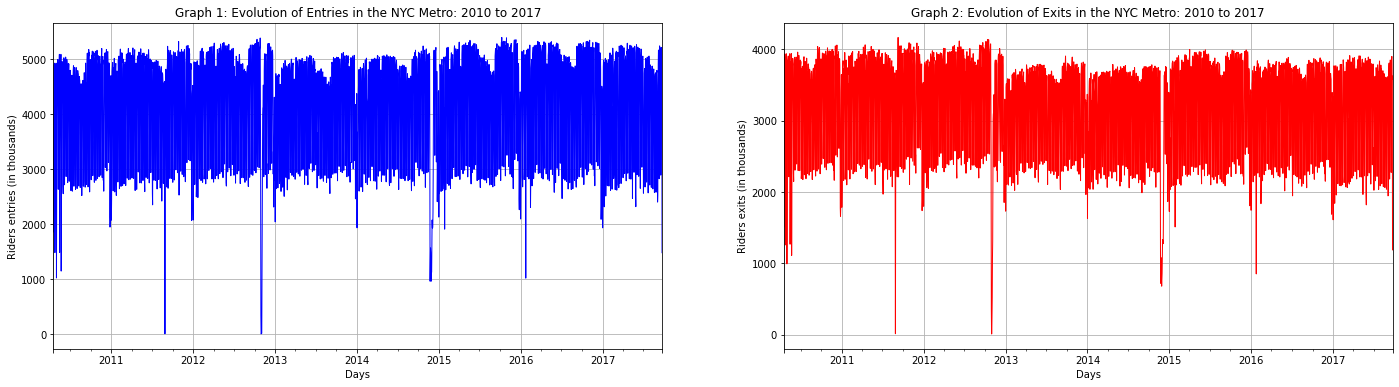

In [25]:
# Define figure sizes
plt.rcParams['figure.figsize'] = [24,6]

# Strings to pass as title and labels for the first graph
title1 = 'Graph 1: Evolution of Entries in the NYC Metro: 2010 to 2017'
xlabel = 'Days'
ylabel = 'Riders entries (in thousands)'

plt.subplot(1,2,1)
ax = DAILY_EN['entries'].plot(title=title1,c='blue',grid=True, linewidth=1)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

title2 = 'Graph 2: Evolution of Exits in the NYC Metro: 2010 to 2017'
ylabel = 'Riders exits (in thousands)'

plt.subplot(1,2,2)
ax = DAILY_EX['exits'].plot(title=title2,c='red',grid=True, linewidth=1)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel = xlabel, ylabel = ylabel)


plt.show()

Yet it is not quite clear the pattern of the time series as both graphs look into many dates. However, apart from some very specific ocurrences, the data is spread 2,000.00 thousand and 5,000.00 thousand entries per day (2,000.00 thousand and 4,000.00 thousand exits). The behaviour between day can be drilled down by slicing the dates and overall patterns by analysing ridership per month

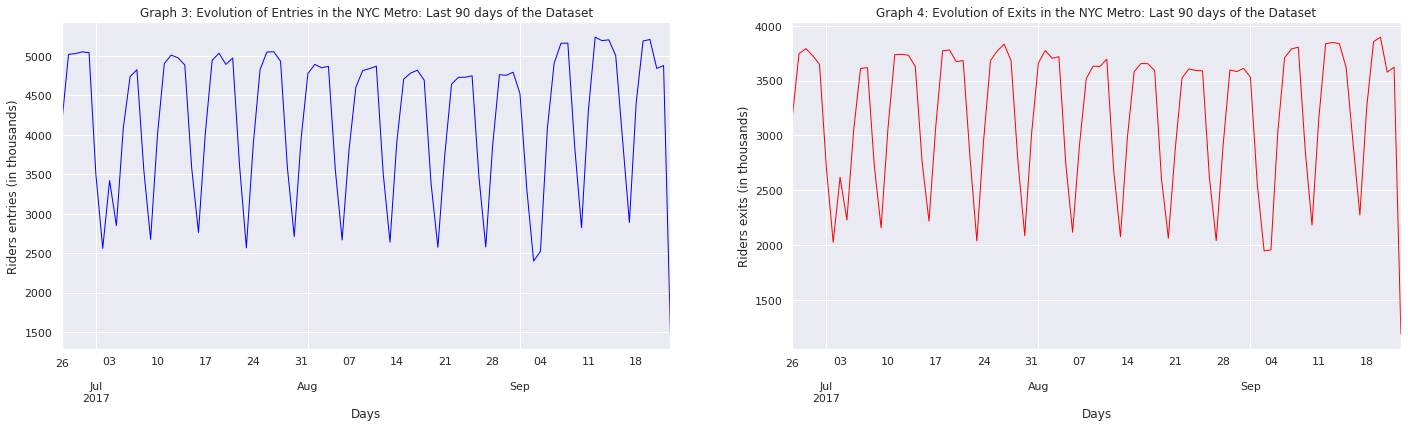

In [150]:
# Define figure sizes
plt.rcParams['figure.figsize'] = [24,6]

# Strings to pass as title and labels for the first graph
title1 = 'Graph 3: Evolution of Entries in the NYC Metro: Last 90 days of the Dataset'
xlabel = 'Days'
ylabel = 'Riders entries (in thousands)'

# And slicer is passed to the dataframe DAILY_EN to reduce the number of days plotted
plt.subplot(1,2,1)
ax = DAILY_EN['entries'][-90:].plot(title=title1,c='blue',grid=True, linewidth=1)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

title2 = 'Graph 4: Evolution of Exits in the NYC Metro: Last 90 days of the Dataset'
ylabel = 'Riders exits (in thousands)'

# And slicer is passed to the dataframe DAILY_EX to reduce the number of days plotted
plt.subplot(1,2,2)
ax = DAILY_EX['exits'][-90:].plot(title=title2,c='red',grid=True, linewidth=1)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel = xlabel, ylabel = ylabel)


plt.show()

Now it is possible to observe that within a month, there is indeed a seasonality in ridership which is naturally result of the behaviour of user during the working week. This also gives strenght to the assumption taken that any missing or zero values in the dataset can be fairly well represented by its backshift at lag - 7. This is of course prior knowledge of the behaviour of subway ridership applied to the data.

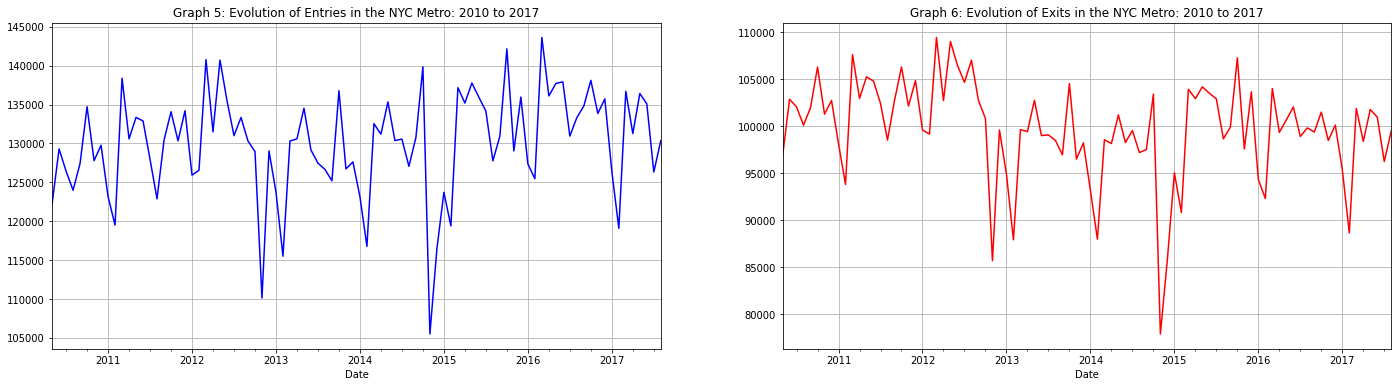

In [27]:
plt.rcParams['figure.figsize'] = [24,6]


title1 = 'Graph 5: Evolution of Entries in the NYC Metro: 2010 to 2017'
xlabel = 'Days'
ylabel = '(k) Riders'

plt.subplot(1,2,1)
ax = MONTH_EN['entries'].plot(title=title1,c='blue',grid=True)
ax.autoscale(axis='x',tight=True)
## ax.set(xlabel=xlabel, ylabel=ylabel)

title2 = 'Graph 6: Evolution of Exits in the NYC Metro: 2010 to 2017'

plt.subplot(1,2,2)
ax = MONTH_EX['exits'].plot(title=title2,c='red',grid=True)
ax.autoscale(axis='x',tight=True)


plt.show()

A boxplot or catplot is helpful to understand data spread along the dataset. This analsis will be done through a violin boxplot of entries and exits to infer whether or not there is classes of data that may be analysed differently.

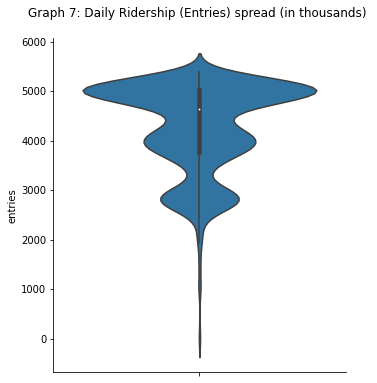

In [28]:
# Plot a graph to analyse data spread through number of entries using a catplot from seaborn
ax = sns.catplot(y='entries', kind='violin', data=DAILY_EN).set(title='Graph 7: Daily Ridership (Entries) spread (in thousands) \n')

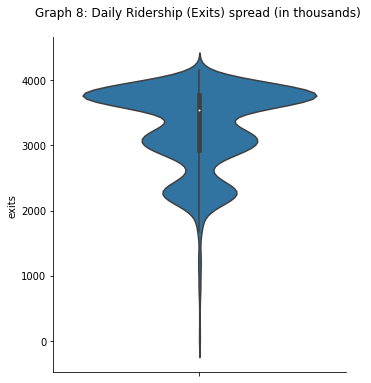

In [29]:
# Plot a graph to analyse data spread through number of entries using a catplot from seaborn
ax = sns.catplot(y='exits', kind='violin', data=DAILY_EX).set(title='Graph 8: Daily Ridership (Exits) spread (in thousands) \n')

On a daily basis, we can see there are 3 different "classes" of entry and exit. One hypothesis for that is the working week itself. This is expected to reflect upon the the seasonality of the data as well.

Now, for the monthly basis dataframe, this does not seem to be true. The timeseries

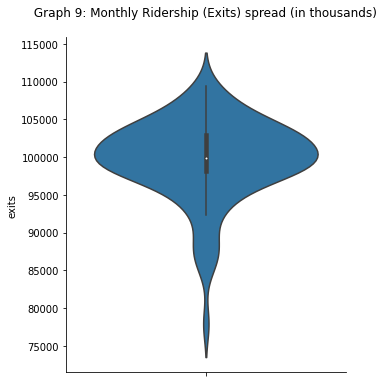

In [30]:
# Plot a graph to analyse data spread through number of entries using a catplot from seaborn
ax = sns.catplot(y='exits', kind='violin', data=MONTH_EX).set(title=' Graph 9: Monthly Ridership (Exits) spread (in thousands) \n')

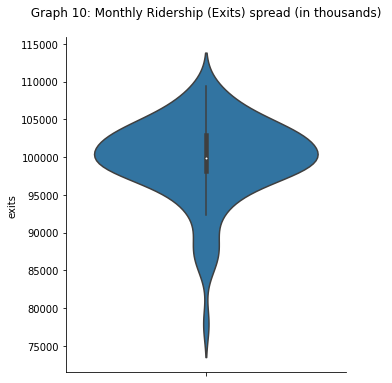

In [31]:
# Plot a graph to analyse data spread through number of entries using a catplot from seaborn
ax = sns.catplot(y='exits', kind='violin', data=MONTH_EX).set(title=' Graph 10: Monthly Ridership (Exits) spread (in thousands) \n')

Hence, it seems there is not a significant difference in the spread of ridership between different months along the year.

Another possible question is what are the busiest stations in NYC Subway. That is relevant because it is possible to isolate them and in turn try and forecast its behaviour individually.

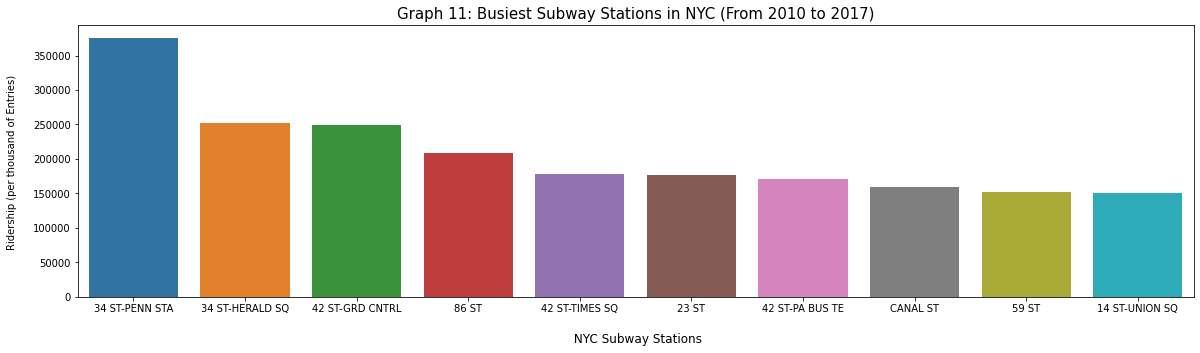

In [32]:
# Set a comfortable reading size for the graph
plt.figure(figsize=(20,5))
# Create a barplot using seaborn to plot the busiest stations in NYC
# The original daily dataframe with station is grouped by station the and then sorted from highest to lowers
# By selecting the first 10 ocurrences, we plot the top 10 station in NYC for the whole analysed period
sns.barplot(x=daily_entries_df.groupby(['station'])['entries'].sum().reset_index().sort_values(['entries'], ascending=False)['station'][:10],
            y=daily_entries_df.groupby(['station'])['entries'].sum().reset_index().sort_values(['entries'], ascending=False)['entries'][:10])
plt.title(label='Graph 11: Busiest Subway Stations in NYC (From 2010 to 2017)',fontsize=15)
plt.xlabel(xlabel='\n NYC Subway Stations',fontsize=12)
plt.ylabel(ylabel='Ridership (per thousand of Entries) \n')
plt.show()

If the data is sliced down to the last two year, i.e., 2016 and 2017, we can observe if the same stations remain relevant of whether there is a shift in ridership

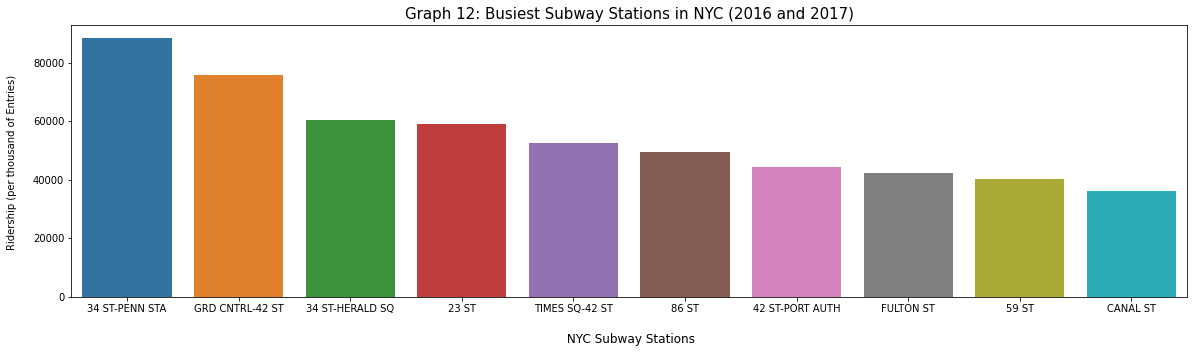

In [33]:
plt.figure(figsize=(20,5))
# The difference in this barplot is slice done in the daily_entries_df using the method loc to retrieve only dates higher data 2016-01-01
sns.barplot(x=daily_entries_df.loc[(daily_entries_df.Date > '2016-01-01'),:].groupby(['station'])['entries'].sum().reset_index().sort_values(['entries'], ascending=False)['station'][:10],
            y=daily_entries_df.loc[(daily_entries_df.Date > '2016-01-01'),:].groupby(['station'])['entries'].sum().reset_index().sort_values(['entries'], ascending=False)['entries'][:10])
plt.title(label='Graph 12: Busiest Subway Stations in NYC (2016 and 2017)',fontsize=15)
plt.xlabel(xlabel='\n NYC Subway Stations',fontsize=12)
plt.ylabel(ylabel='Ridership (per thousand of Entries) \n')
plt.show()

It is observed that **34 ST-PENN STA** remains as the busiest station in terms of entries. Also, from the whole dataset to the sliced 2016-2017, we observe that **42 ST-GRD CNTRL** desappears and **GRD CNTRL-42 ST** arises. As a fun fact, indeed both names are used for the same station. That maybe so for different stations, but this will not be object of analysis now. In terms of exits, it seems that the pattern is maintened. 

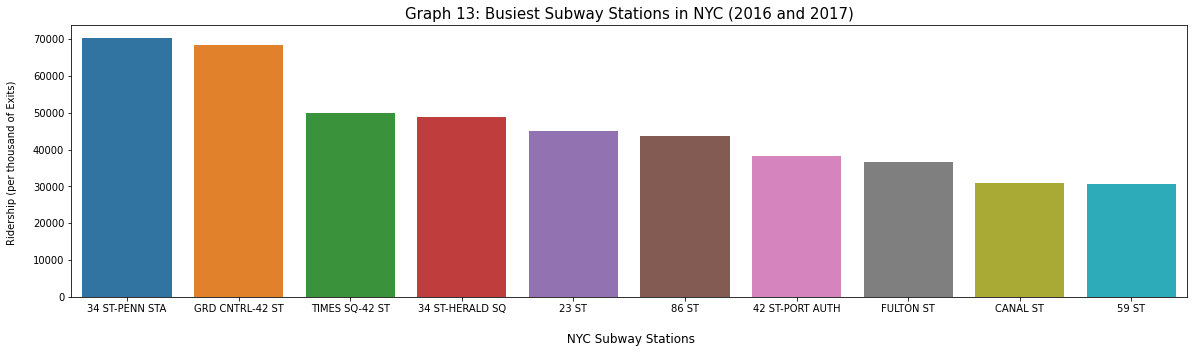

In [34]:
plt.figure(figsize=(20,5))
# The difference in this barplot is slice done in the daily_entries_df using the method loc to retrieve only dates higher data 2016-01-01
sns.barplot(x=daily_exits_df.loc[(daily_exits_df.Date > '2016-01-01'),:].groupby(['station'])['exits'].sum().reset_index().sort_values(['exits'], ascending=False)['station'][:10],
            y=daily_exits_df.loc[(daily_exits_df.Date > '2016-01-01'),:].groupby(['station'])['exits'].sum().reset_index().sort_values(['exits'], ascending=False)['exits'][:10])
plt.title(label='Graph 13: Busiest Subway Stations in NYC (2016 and 2017)',fontsize=15)
plt.xlabel(xlabel='\n NYC Subway Stations',fontsize=12)
plt.ylabel(ylabel='Ridership (per thousand of Exits) \n')
plt.show()

### **Temporality** Analysis and Data Separation

In [146]:
# Divide the daily entries dataset in test and train
# 90% of the dataset will be for train
train = DAILY_EN[:math.floor(DAILY_EN.shape[0]*0.9)]
# 10% of the dataset will be for test
test = DAILY_EN[-math.floor(1+DAILY_EN.shape[0]*0.1):]
# Define a dataframe for a more sliced analysis
train_chunked = train[-400:]

# 90% of the dataset will be for train
train = MONTH_EN[:math.floor(MONTH_EN.shape[0]*0.9)]
# 10% of the dataset will be for test
test = MONTH_EN[-math.floor(1+MONTH_EN.shape[0]*0.1):]

Graph 14: Seasonal Decompose of daily entries times series 



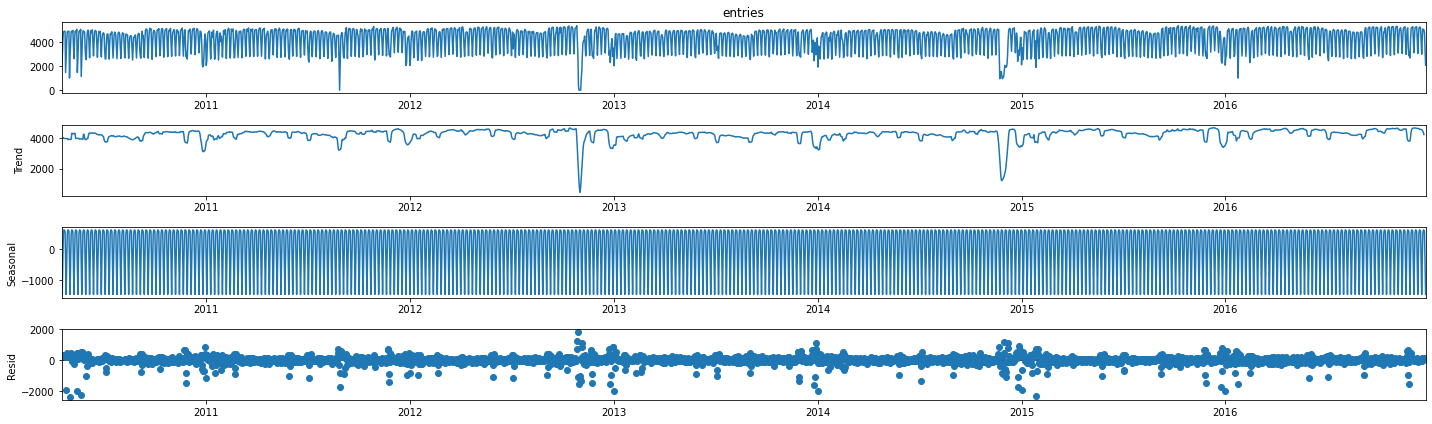

In [36]:
# By using the function seasonal_decompose from statsmodels it is possible to further analyse the temporal behaviour
print('Graph 14: Seasonal Decompose of daily entries times series \n')
plt.rcParams['figure.figsize'] = [20,6]
#result_c = seasonal_decompose(train['entries'], model='additive', freq=7)
result_c = seasonal_decompose(train['entries'])
result_c.plot()
plt.show()

There is residual information for daily ridership (entries basis), but not so intensely distributed. However, around the end of each year it increases. The seasonal behaviour can also be observed. As for trend, it does not seem a trend up or downwards in the dataset. Lets use a more sliced chunk of data to better observe its components.

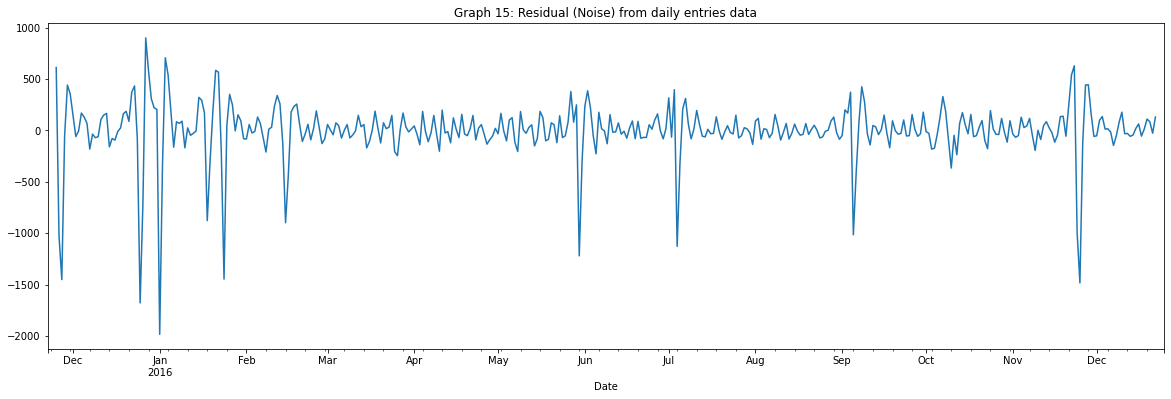

In [37]:
# Use the train_chunk dataframe for more granular information
plt.rcParams['figure.figsize'] = [20,6]
#result_c = seasonal_decompose(train_chunked['entries'], model='additive', freq=7)
result_c = seasonal_decompose(train_chunked['entries'])
# First, plot the residual (noise) from the data
plt.title('Graph 15: Residual (Noise) from daily entries data')
result_c.resid.plot()
plt.show()

Thus verifying the original note that around the end of the year it is higher the likelihood of great variance in ridership. 

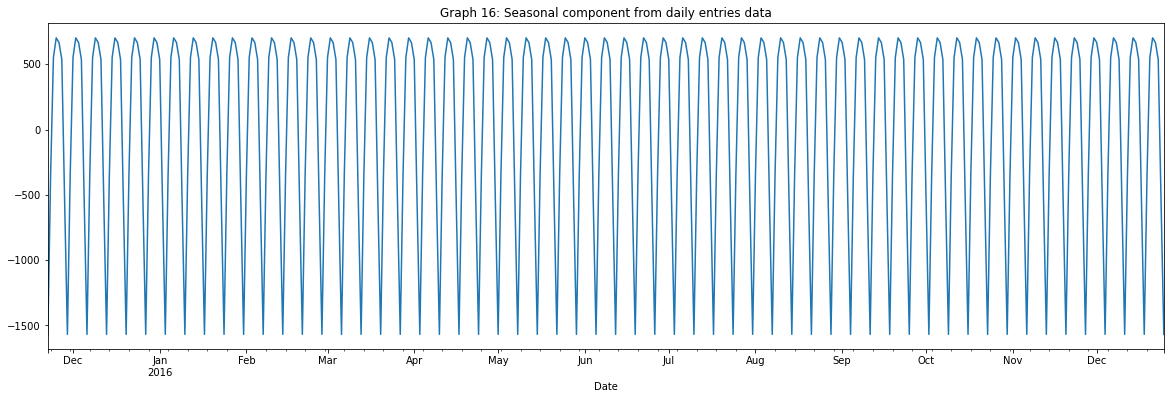

In [38]:
# Use the train_chunk dataframe for more granular information
plt.rcParams['figure.figsize'] = [20,6]
# First, plot the seasonal component from the data
plt.title('Graph 16: Seasonal component from daily entries data')
result_c.seasonal.plot()
plt.show()

The seasonality is well defined in the daily entries series as previously noted.

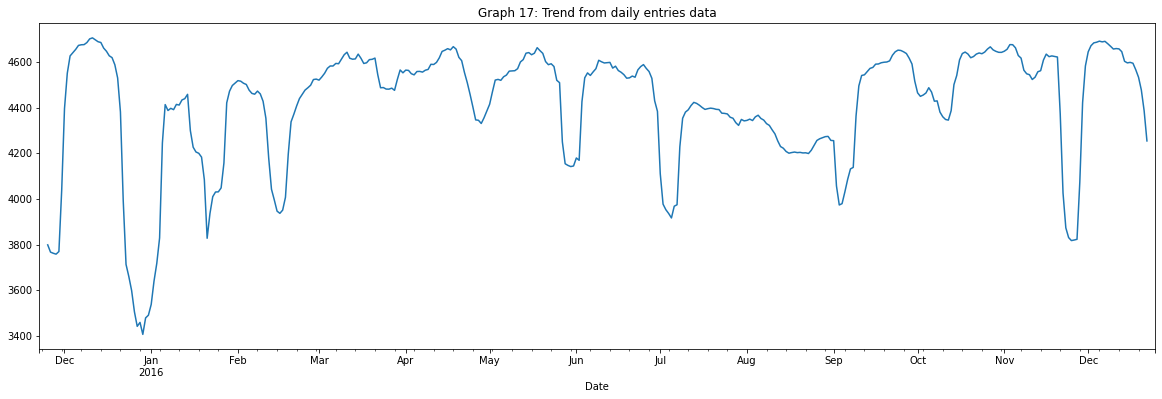

In [39]:
# Use the train_chunk dataframe for more granular information
plt.rcParams['figure.figsize'] = [20,6]
# First, plot the seasonal component from the data
plt.title('Graph 17: Trend from daily entries data')
result_c.trend.plot()
plt.show()

There is no clear trend in the data.

By the behaviour of the times series, the stationary hypothesis is likely with low residue and well behaved trend and seasonality. Using a Dickey-Fuller teste we can statistically infer whether or not the hypothesis holds. 

In [40]:
# Use the function adfuller on train to 
result_m = adfuller(train['entries'], autolag='AIC')
print(f'Dickey-Fuller test: {result_m[0]} \n')
print(f'p-Valor: {result_m[1]}')
for key, value in result_m[4].items():
  print('\t%s: %.3f' % (key,value))

Dickey-Fuller test: -6.55617245775279 

p-Valor: 8.605615893429909e-09
	1%: -3.433
	5%: -2.863
	10%: -2.567


The Dickey-Fuller test allows to accept the hypothesis of stationarity due to the low p-Value.

The autocorrelation plots also help understand how the current variable is related to itselft when backshifted.

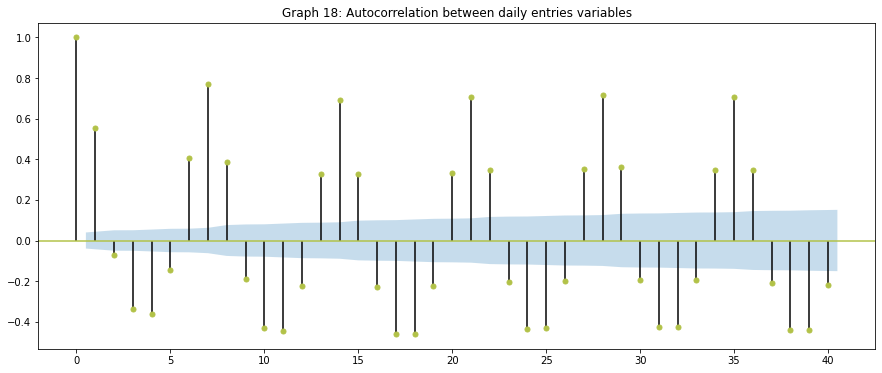

In [41]:
plt.rcParams['figure.figsize'] = [15,6]
lags = 40
plot_acf(train['entries'],title='Graph 18: Autocorrelation between daily entries variables',lags=lags,color='#B2C248');

Indeed the entries variable has a strong correlectation with its backshift, specially at lags = 1, 6, 7, 8, 13, 14, 15, 20, 21, ...

This adds up to the fact that the seasonal component is important and the well behaved series can be backshifted for many periods and still hold relevance to the current entries variable.

## Forecasting Model: Daily Entries

### Holt-Winters

In [42]:
sns.set(style="darkgrid")

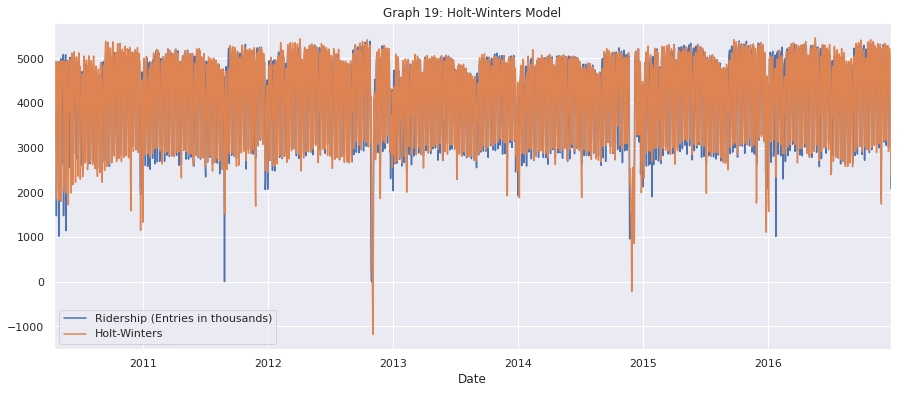

In [43]:
# ExponentialSmoothing function from statsmodels allows to capture the time series behaviour
HW_MODEL = ExponentialSmoothing(train['entries'],trend='add',seasonal='add',seasonal_periods=7).fit();
# By observing entries and smoothing the time series, HW models can fit values that will replicate the smoothness of the train data
train['Holt-Winters'] = HW_MODEL.fittedvalues
train['entries'][:].plot(legend=True,label='Ridership (Entries in thousands)')
train['Holt-Winters'][:].plot(legend=True,label='Holt-Winters')
plt.title('Graph 19: Holt-Winters Model')
plt.show()

In [44]:
HW_PREDICT = HW_MODEL.forecast(test.shape[0]).rename('Holt-Winters Model')

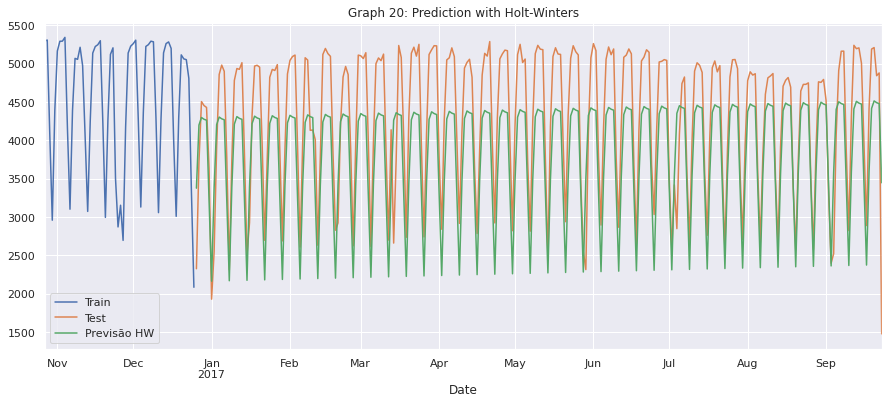

In [94]:
train['entries'][-60:].plot(legend=True,label='Train')
test['entries'].plot(legend=True,label='Test')
HW_PREDICT.plot(legend=True,label='Previsão HW')
plt.title('Graph 20: Prediction with Holt-Winters')
plt.show()

In [46]:
# Use MAPE functions from statsmodels to evaluate the error for prediction in the test dataset
MAPE_HW = mean_absolute_percentage_error(test['entries'],HW_PREDICT)
print(f'MAPE = {round(100*MAPE_HW,2)}%')

MAPE = 13.88%


### SARIMAX

In [ ]:
# From pmdarima, auto_arima is an optimization algorythm that search the optimal parameters for SARIMAX
auto_arima(DAILY_EN['entries'],seasonal=True,m=7).summary()
stepwise_fit = auto_arima(DAILY_EN['entries'], start_p=0, start_q=0, max_p=6, max_q=3, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=39908.175, Time=9.78 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=44423.393, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=41066.631, Time=5.35 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=42727.773, Time=2.85 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=44421.393, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=42829.625, Time=2.08 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=41072.533, Time=2.47 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=14.65 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=40650.851, Time=11.42 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=42221.423, Time=4.01 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=6.73 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=21.14 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=14.01 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=39995.739, Time=7.70 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2717
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -19950.140
Date:                             Fri, 25 Nov 2022   AIC                          39906.280
Time:                                     10:23:32   BIC                          39924.000
Sample:                                          0   HQIC                         39912.686
                                            - 2717                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9995      0.000   7270.441      0.000       0.999       1.000
ma.S.L7       -0.9265      0.007   -138.965      0.000      -0.940      -0.913
sigma2      1.388e+05   1321.475    105.026      0.000    1.36e+05    1.41e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.26   Jarque-Bera (JB):             24515.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -1.36
Prob(H) (two-sided):                  0.01   Kurtosis:                        17.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
# Pass the parameters for SARIMAX to create the model
SARIMAX_MODEL = SARIMAX(DAILY_EN['entries'],order=(0,1,0),seasonal_order=(1,0,1,7)).fit()
SARIMAX_MODEL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             entries   No. Observations:                 2717
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -19950.140
Date:                             Fri, 25 Nov 2022   AIC                          39906.280
Time:                                     10:42:48   BIC                          39924.000
Sample:                                 04-17-2010   HQIC                         39912.686
                                      - 09-23-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9995      0.000   7270.451      0.000       0.999       1.000
ma.S.L7       -0.9265      0.007   -138.965      0.000      -0.940      -0.913
sigma2      1.388e+05   1321.476    105.026      0.000    1.36e+05    1.41e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.26   Jarque-Bera (JB):             24515.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -1.36
Prob(H) (two-sided):                  0.01   Kurtosis:                        17.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
start = len(train)
end = len(train)+len(test)-1
SARIMAX_PREDICT = SARIMAX_MODEL.predict(start=start, end=end, dynamic=False, typ='levels').rename('sARIMAX Model (0,1,0)(1,0,1,7)')
SARIMAX_PREDICT.index = test.index

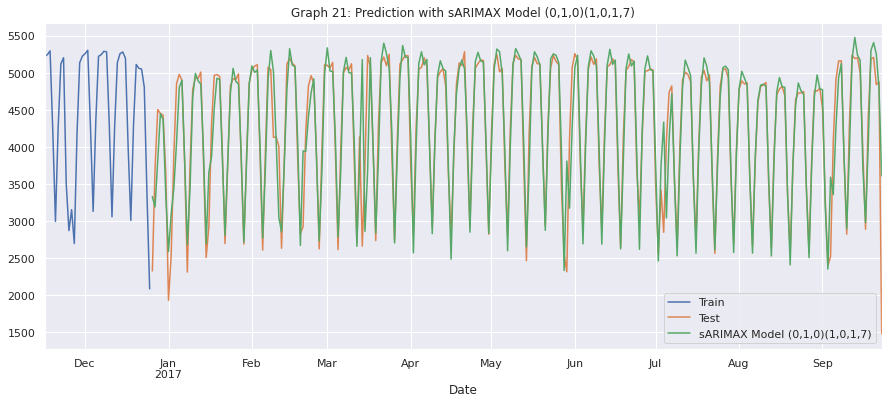

In [95]:
train['entries'][-40:].plot(legend=True,label='Train')
test['entries'].plot(legend=True,label='Test')
SARIMAX_PREDICT.plot(legend=True,label='sARIMAX Model (0,1,0)(1,0,1,7)')
plt.title('Graph 21: Prediction with sARIMAX Model (0,1,0)(1,0,1,7)')
plt.show()

In [96]:
MAPE_SARIMAX = mean_absolute_percentage_error(test['entries'],SARIMAX_PREDICT)
print(f'O Erro Absoluto Médio é: MAE = {round(100*MAPE_SARIMAX,2)}%')

O Erro Absoluto Médio é: MAE = 5.93%


### Método **Theta**

In [51]:
TM_MODEL = ThetaModel(train['entries'],method = 'additive').fit()
print(TM_MODEL.summary())

                              ThetaModel Results                              
Dep. Variable:                entries   No. Observations:                 2445
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Fri, 25 Nov 2022   Deseas. Method:               Additive
Time:                        10:42:58   Period:                              7
Sample:                    04-17-2010                                         
                         - 12-25-2016                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    0.07845119559446058
alpha  0.8185422350234005
-------------------------


In [52]:
TM_MODEL = ThetaModel(train['entries'], deseasonalize=True, period=7).fit()
TM_PREDICT = TM_MODEL.forecast(test.shape[0]).to_frame().set_index(test.index)

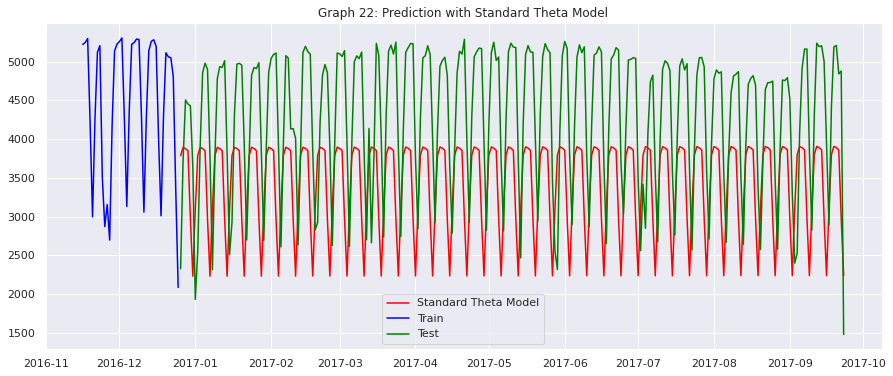

In [116]:
plt.plot(TM_PREDICT, color='red', label = 'Standard Theta Model')
plt.plot(train['entries'][-40:], color='blue', label='Train')
plt.plot(test['entries'], color='green', label='Test')
plt.title('Graph 22: Prediction with Standard Theta Model')
plt.legend()
plt.show()


In [97]:
MAPE_TM = mean_absolute_percentage_error(test['entries'],TM_PREDICT)
print(f'O Erro Absoluto Médio é: MAE = {round(100*MAPE_TM,2)}%')

O Erro Absoluto Médio é: MAE = 24.89%


### LSTM

In [101]:
# Create a different dataset for training the LSTM model once test was used to create another column with exponential smoothing
train.LSTM = train.drop(columns=['Holt-Winters'])


In [57]:
train.LSTM.head(2)

,entries
Date,
2010-04-17,1856.47
2010-04-18,2721.10


In [58]:
#Declare a variable to apply the function MinMaxScaler that will scale values from 1 to 0
scaler = MinMaxScaler()

In [59]:
# Fit the data according to the train dataset and apply to both later
scaler.fit(train.LSTM)

MinMaxScaler()

In [102]:
# Create a scaled train dataset
scaled_train = scaler.transform(train.LSTM)

In [106]:
# Create a scaled test dataset
scaled_test = scaler.transform(test)

In [107]:
print(scaled_train.min(),scaled_train.max())

0.0 0.9999999999999999


In [108]:
print(scaled_test.min(), scaled_test.max())

0.2740670806605324 0.9805745811377823


In [129]:
# Declare the number of input layers into the LSTM
n_input = 7
n_features = 1
# Create a times series that matches the shape of the input data into LSTM
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size = 1)

In [130]:
# Declare the ML layers
# Sequential model
LSTM_MODEL = Sequential(name = 'LSTM1')
# First layer: LSTM 100 with RELU activation
LSTM_MODEL.add(LSTM(100,activation='relu',input_shape = (n_input, n_features)))
# Dense layer to output data in a readable and comprehensive shape
LSTM_MODEL.add(Dense(1))
LSTM_MODEL.compile(optimizer='adam', loss = 'mse')

In [131]:
LSTM_MODEL.summary()

Model: "LSTM1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [132]:
# Train the model by fitting to the generated times series for scaled_train
LSTM_MODEL.fit(generator, epochs = 25)

Epoch 1/25
2438/2438 [==============================] - 14s 5ms/step - loss: 0.0194
Epoch 2/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0095
Epoch 3/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.0079
Epoch 4/25
2438/2438 [==============================] - 9s 4ms/step - loss: 0.0075
Epoch 5/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0069
Epoch 6/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0067
Epoch 7/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0068
Epoch 8/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0063
Epoch 9/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0060
Epoch 10/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0057
Epoch 11/25
2438/2438 [==============================] - 10s 4ms/step - loss: 0.0055
Epoch 12/25
2438/2438 [==============================] - 11s 4ms/step - loss

Text(0.5, 1.0, 'Graph 23: Loss per Epoch on LSTM Training')

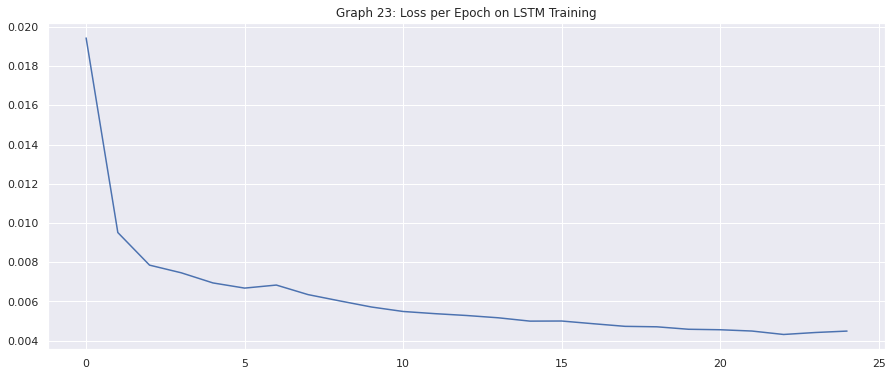

In [133]:
loss_per_epoch = LSTM_MODEL.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Graph 23: Loss per Epoch on LSTM Training')

In [134]:
first_eval_batch = scaled_train[-n_input:]

In [135]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [136]:
LSTM_MODEL.predict(first_eval_batch)

array([[0.5914151]], dtype=float32)

In [137]:
test_prediction = []
first_eval_batch = scaled_train[-n_input:]

In [138]:
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [139]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.94840654],
        [ 0.93875691],
        [ 0.93680209],
        [ 0.89173448],
        [ 0.62346341],
        [ 0.38671273],
        [99.        ]]])

In [140]:
# Agora vamos considerar as previsões para as próximas 21 observações e comparar com a base de teste

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = LSTM_MODEL.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [141]:
true_prediction = scaler.inverse_transform(test_predictions)

In [142]:
test['Predictions'] = true_prediction

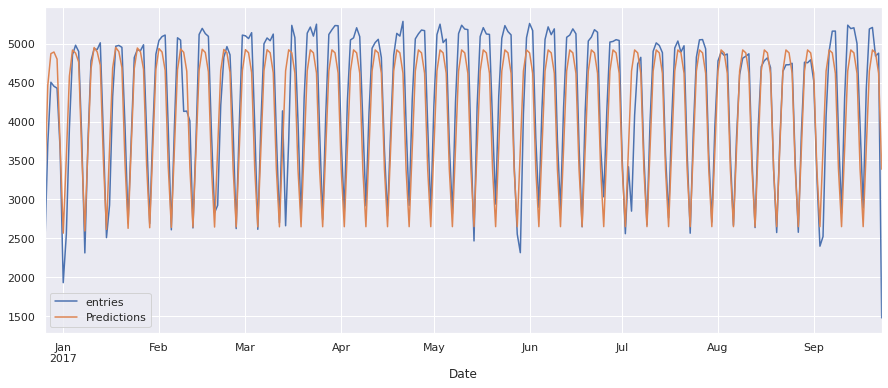

In [143]:
test.plot()

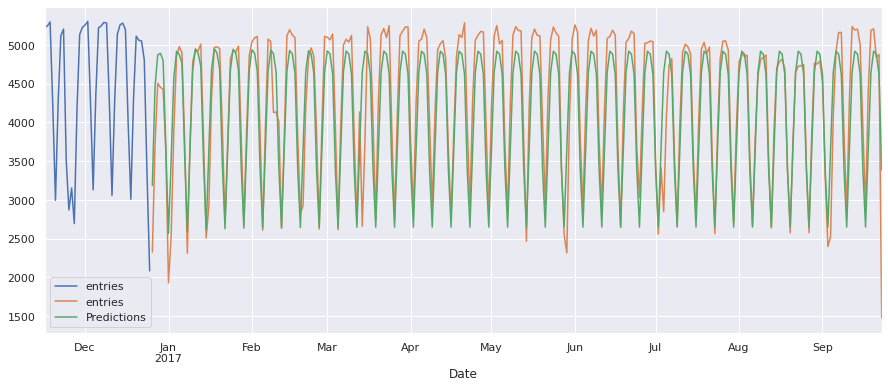

In [144]:
ax = train[-40:].plot()
test.plot(ax=ax)

In [145]:
MAPE_LSTM = round(100*mean_absolute_percentage_error(test['entries'],test['Predictions']),2)
print(f'Mean Absolute Percentage Error MAPE = {MAPE_LSTM}%')

Mean Absolute Percentage Error MAPE = 8.4%


## Conclusion

Daily ridership in the NYC Subway is well rounded at 3 million to 5 million rides per day as shown in Graph 1. Graph 7 suggests that ridership seems to be well distributed around 3 peaks: 5, 4 and 3 million. It is inferred that this is a direct result of different patterns of usage during the working week. Moreover, indeed graph 18 reveals a strong autocorrelation of the variable entry at lags = 1, 6, 7, 8, 13, 14, 15, 20, 21, ...

For daily predictions, the models tested were: Holt-Winters, SARIMAX, Theta and LSTM. The best prediction model for daily ridership was **SARIMAX** with **MAPE = 5,93%**. 

The busiest stations by entries were shown in graph 11 and 12, which confirmed **34 ST-PENN STA** as the busiest. However some stations did change positions when comparing the full dataset and entries from 2016 to 2017.



### Suggestions

Due to the change in some of the busiest stations, it may be interesting to forecast individual usage of the stations in prediction models. More than that, a forecast model with multiple variables for each station could also give insights could better capture usage behaviour and distribution. 

Another suggestion is to better train the LSTM model to reduce total loss of the model by tuning its parameters.